# Training covid models
### This notebook is an example usage of how to use the model alongside the covid-data-collector in order to train, evaluate and test the model
#### In this notebook you will find example usages on how to use the core functionalities of the model 

#### Import third party modules, and also the data_collector: covid19_genome and the model module

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Uncomment to disable GPU
import sys
import numpy as np

from model import Model, DatasetName, load_model, remove_model

__ORIG_WD__ = os.getcwd()

sys.path.append(f"{__ORIG_WD__}/../data_collectors/")
os.chdir(f"{__ORIG_WD__}/../data_collectors/")
from covid19_genome import Covid19Genome

os.chdir(__ORIG_WD__)

import tensorflow as tf


2023-12-28 12:18:27.247560: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-28 12:18:27.273340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-28 12:18:27.634549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Create a model, or try to load it, if it was already have been created.

In order to use the model, the first thing you have to do is provide it with a dataset (with the help of the data_collector). In the following cell you are provided with an example that create the dataset.

In this instance, we will load the lineages of the 10/1/2021 UShER tree. This notebook is created for the study of identifying new lineages.

You should note that when you are creating the dataset, you are passing the dataset type. You can obtain the available dataset types in the system by calling the model class function ```get_ds_types()```

In [2]:
model_name = "covid19-new_lineages"

try:
    model = load_model(model_name)
except Exception:
    covid19_genome = Covid19Genome()
    lineages = covid19_genome.getLocalLineages(512)
    lineages_set = set(lineages)
    
    # Decide lineages to train on (defined in the lineages_in_tree.txt file)
    lineages_in_tree = []
    with open("lineages_in_tree.txt", "r") as f:
        for line in f:
            lineage = line.split("\t")[0]
            if lineage in lineages_set:
                lineages_in_tree.append(lineage)
    print(f"The number of lineages located in the tree is: {len(lineages_in_tree)}")

    lineages_in_tree.sort()
    dataset = []
    def get_dataset():
        for lineage in lineages_in_tree:
            dataset.append((lineage, covid19_genome.getLocalAccessionsPath(lineage)))
        return dataset

    portions = {
        DatasetName.trainset.name: 0.8,
        DatasetName.validset.name: 0.1,
        DatasetName.testset.name: 0.1
    }

    dataset = get_dataset()
    
    model = Model(model_name)
    model.create_datasets(model.get_ds_types()[0], dataset, portions)

2023-12-28 12:18:38.723609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-28 12:18:38.739120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-28 12:18:38.739228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

After you have created the model, and created its datasets. You can check which neural network structures is available. You can do that by calling the model class function ```get_ml_model_structure()```.

After you see all the ml_model structures available in the system, you can check which hyper parameters are needed to define each and every ml_model structure. This is done by calling the model class function ```get_ml_model_structure_hps()```. The ```get_ml_model_structure_hps()``` will return which hps are required, and what it their type.

In [3]:
print(model.get_ml_model_structures())
print(model.get_ml_model_structure_hps(model.get_ml_model_structures()[0]))

['VitStructure', 'IreneStructure', 'SandyStructure']
{'d_model': 'required', 'd_val': 'required', 'd_key': 'required', 'd_ff': 'required', 'heads': 'required', 'dropout_rate': 'optional', 'regularizer': 'optional', 'initializer': 'optional', 'activation': 'optional', 'encoder_repeats': 'required', 'labels': 'required'}


You can also see which properties help define the current type of dataset by calling to the model class function ```get_ds_props()``` This function could be called only after the dataset have been succesfully created. This function will return the properties of the dataset as well as their values.

In [4]:
print(model.get_ds_props())

{'coverage': 4, 'substitution_rate': 0.0, 'insertion_rate': 0.0, 'deletion_rate': 0.0, 'read_length': 128, 'frag_len': 288, 'num_frags': 256}


A use case of the system with the VitStructure model and the minhash genome datasets (a.k.a. mh_genome_ds).

In the mh_genome_ds the coverage is a dataset property that sets the genome coverage rate.

In the VitStructure, the model_depth is the number of transformer encoders.

In this example use-case these two parameters will help us define a neural network that will be trained on the dataset (with the current coverage rate)

In [5]:
coverage = 4
ml_model_depth = 1
sequencer_instrument = "ideal"

In [6]:
sequencer_instrument_to_error_profile_map = {
    "ideal": {
        "substitution_rate": 0.0,
        "insertion_rate": 0.0,
        "deletion_rate": 0.0
    },
    "illumina": {
        "substitution_rate": 0.005,
        "insertion_rate": 0.001,
        "deletion_rate": 0.001
    },
    "ont": {
        "substitution_rate": 0.01,
        "insertion_rate": 0.04,
        "deletion_rate": 0.04
    },
    "pacbio": {
        "substitution_rate": 0.005,
        "insertion_rate": 0.025,
        "deletion_rate": 0.025
    },
    "roche": {
        "substitution_rate": 0.002,
        "insertion_rate": 0.01,
        "deletion_rate": 0.01
    }
}

def get_model_name(ml_model_depth, coverage, sequencer_instrument):
    if not sequencer_instrument in sequencer_instrument_to_error_profile_map:
        raise Exception(f"Invalid sequencer instrument: {sequencer_instrument}")
    return f"vit.{ml_model_depth}.{coverage}x.{sequencer_instrument}"

ml_model_name = get_model_name(ml_model_depth, coverage, sequencer_instrument)

#### Adding a new neural network

In this cell we will create an ml_model with the required hps (and also optional) as outputted earlier.

In [7]:
newly_added = True
try:
    model.add_ml_model(ml_model_name, hps={
        "structure": model.get_ml_model_structures()[0],
        "d_model": model.get_ds_props()["frag_len"],
        "d_val": 128,
        "d_key": 128,
        "heads": 8,
        "d_ff": 1024+256,
        "labels":  len(model.get_labels()),
        "activation": "relu",
        "optimizer": {
            "name": "AdamW",
            "params": {
                "learning_rate": 0.001,
            },
        },
        "encoder_repeats": ml_model_depth,
        "regularizer": {
            "name": "l2",
            "params": {
                "l2": 0.0001
            }
        },
        "dropout": 0.2,
    })
except:
    newly_added = False
    print("Model already exists")

Model already exists


In [8]:
models = model.list_ml_models()
print(models)

['vit.1.4x.ideal']


In [9]:
if newly_added:
    # assert False, "Please consider doing transfer learning"
    pass
# model.transfer(get_model_name(ml_model_depth, coverage * 2, sequencer_instrument), ml_model_name, False)

In [10]:
# model.change_ml_hps(ml_model_name, {
#     "regularizer": {
#         "name": "l2",
#         "params": {
#             "l2": 0.00005,
#         },
#     },
#     "optimizer": {
#         "name": "AdamW",
#         "params": {
#             "learning_rate": 0.0002,
#         },
#     },
# })

#### Updating the dataset coverage

In [11]:
# model.update_ds_props({
#     "coverage": coverage,
#     } | sequencer_instrument_to_error_profile_map[sequencer_instrument])

#### Setting dataset batch size and training

In [12]:
# model.set_ds_batch_size(512)
# model.train(ml_model_name, epochs=1000)

In [13]:
# prepare data of new lineages
covid19_genome = Covid19Genome()
lineages = covid19_genome.getLocalLineages(512)
lineages_set = set(lineages)

# Decide lineages to train on (defined in the lineages_in_tree.txt file)
lineages_in_tree = []
with open("lineages_in_tree.txt", "r") as f:
    for line in f:
        lineage = line.split("\t")[0]
        if lineage in lineages_set:
            lineages_in_tree.append(lineage)
print(f"The number of lineages located in the tree is: {len(lineages_in_tree)}")

lineages_not_in_tree = list(lineages_set - set(lineages_in_tree))
lineages_not_in_tree.sort()

Building Data frame
Done building Data frame
Building remote dicts
Done building remote dicts
Building local dicts
Done building local dicts
The number of lineages located in the tree is: 77


In [14]:
# print("dataset types: ")
# print(model.get_ds_types())
# print("dataset properties: ")
# print(model.get_ds_props())

In [15]:
def get_usher_results():
    new_accessions_list = []
    usher_results = {}
    with open("usher_results.txt", "r") as f:
        for idx, line in enumerate(f):
            if idx % 2 == 1:
                continue
            else:
                accession_path = line.split("\t")[0]
                accession = accession_path.split("/")[-1].split(".")[0]
                new_accessions_list.append(accession_path)
                
                real_lineage = line.split("\t")[1]
                predicted_lineages = [result.split("(")[0] for result in line.split("\t")[-1].split("|")[-1].split(",")]
                if not real_lineage in usher_results:
                    usher_results[real_lineage] = {}
                usher_results[real_lineage][accession] = set(predicted_lineages)
    return usher_results, new_accessions_list

In [16]:
def get_vital_results(new_accessions_list, k=1):
    predicted = model.predict(
        ml_model_name=ml_model_name,
        dataset_type=model.get_ds_types()[0],
        dataset_props=model.get_ds_props(),
        examples=new_accessions_list,
        top_k=k
    )
    vital_results = []
    for i in range(k):
        vital_results.append({})
        for accession_path in predicted:
            accession = accession_path.split("/")[-1].split(".")[0]
            real_lineage = covid19_genome.getAccessionLineage(accession)
            predicted_lineages = predicted[accession_path]["labels"][:i+1]
            if not real_lineage in vital_results[-1]:
                vital_results[-1][real_lineage] = {}
            vital_results[-1][real_lineage][accession] = set(predicted_lineages)
    return vital_results


In [17]:
number_of_experiments = 10
def get_cumulative_lineage_accuracy(vital_results, usher_results):
    accuracy_results = np.zeros([len(usher_results), number_of_experiments])
    real_lineages = list(usher_results.keys())
    real_lineages.sort()
    for lin_idx, real_lineage in enumerate(real_lineages):
        for genome_idx, accession in enumerate(usher_results[real_lineage]):
            if len(vital_results[real_lineage][accession] & usher_results[real_lineage][accession]) > 0:
                accuracy_results[lin_idx][genome_idx:] += 1
                break
    return accuracy_results

def get_lineage_accuracy_per_experiment(vital_results, usher_results):
    accuracy_results = np.zeros([len(usher_results), number_of_experiments])
    real_lineages = list(usher_results.keys())
    real_lineages.sort()
    for lin_idx, real_lineage in enumerate(real_lineages):
        for genome_idx, accession in enumerate(usher_results[real_lineage]):
            if len(vital_results[real_lineage][accession] & usher_results[real_lineage][accession]) > 0:
                accuracy_results[lin_idx][genome_idx] += 1
    return accuracy_results

In [19]:
def get_cumulative_avg_accuracy(vital_results, usher_results):
    accuracy_results = np.zeros(number_of_experiments)
    for real_lineage in usher_results:
        if not real_lineage in vital_results:
            print(f"Lineage {real_lineage} is not in vital results")
            continue
        for idx, accession in enumerate(usher_results[real_lineage]):
            if not accession in vital_results[real_lineage]:
                print(f"Accession {accession} is not in vital results")
                continue
            if len(usher_results[real_lineage][accession] & vital_results[real_lineage][accession]) > 0:
                accuracy_results[idx:] += 1
                break

    return accuracy_results / len(usher_results)

def get_avg_accuracy(vital_results, usher_results):
    accuracy_results = np.zeros(number_of_experiments)
    for real_lineage in usher_results:
        if not real_lineage in vital_results:
            print(f"Lineage {real_lineage} is not in vital results")
            continue
        for idx, accession in enumerate(usher_results[real_lineage]):
            if not accession in vital_results[real_lineage]:
                print(f"Accession {accession} is not in vital results")
                continue
            if len(usher_results[real_lineage][accession] & vital_results[real_lineage][accession]) > 0:
                accuracy_results[idx] += 1

    return accuracy_results / len(usher_results)

In [20]:
def experiment(k, avg = True, cumulative = True): # k is the number of erxperiments to run and it indicates the top-k accuracy
    if avg:
        if cumulative:
            accuracy_calculator = get_cumulative_avg_accuracy
        else:
            accuracy_calculator = get_avg_accuracy
    else:
        if cumulative:
            accuracy_calculator = get_cumulative_lineage_accuracy
        else:
            accuracy_calculator = get_lineage_accuracy_per_experiment
    usher_results, new_accessions_list = get_usher_results()
    vital_results = get_vital_results(new_accessions_list, k)
    return [accuracy_calculator(vital_results_per_k, usher_results) for vital_results_per_k in vital_results]

In [37]:
topk=10
concat_acc_results = [np.array([]) for _ in range(topk)]
for i in range(100):
    accuracy_results = experiment(topk, avg=True, cumulative=False)
    accuracy_results[0] += 0.04
    for j in range(topk):
        concat_acc_results[j] = np.concatenate([concat_acc_results[j], accuracy_results[j]])

In [40]:
#write concated results to csv file
import csv
with open('accuracy_results.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    #write descriptor line
    writer.writerow(["topk"] + [i+1 for i in range(topk)])
    for i in range(len(concat_acc_results[0])):
        list_to_write = [i+1]
        for row in concat_acc_results:
            list_to_write.append(row[i]+0.01)
        writer.writerow(list_to_write)

Top 1 accuracy: 0.7225663716814159
Top 1 accuracy std: 0.014269482740351388
Top 2 accuracy: 0.8197345132743362
Top 2 accuracy std: 0.021767033409289975
Top 3 accuracy: 0.898495575221239
Top 3 accuracy std: 0.015929203539822984
Top 4 accuracy: 0.9427433628318584
Top 4 accuracy std: 0.011332963252093556
Top 5 accuracy: 0.9604424778761061
Top 5 accuracy std: 0.012639696333704134
Top 6 accuracy: 0.9639823008849557
Top 6 accuracy std: 0.013006140227167295
Top 7 accuracy: 0.964867256637168
Top 7 accuracy std: 0.012166130163599551
Top 8 accuracy: 0.9666371681415928
Top 8 accuracy std: 0.013391810575594278
Top 9 accuracy: 0.9666371681415928
Top 9 accuracy std: 0.013391810575594278
Top 10 accuracy: 0.9692920353982301
Top 10 accuracy std: 0.012004123863938503


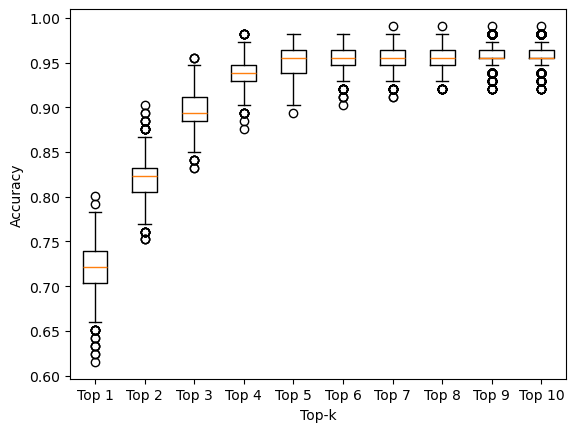

In [42]:
# plot 5 box plots for each k
for i in range(topk):
    print(f"Top {i+1} accuracy: {np.mean(accuracy_results[i])+0.01}")
    print(f"Top {i+1} accuracy std: {np.std(accuracy_results[i])}")

import matplotlib.pyplot as plt
plt.boxplot(concat_acc_results)
plt.xticks([i+1 for i in range(topk)], [f"Top {i+1}" for i in range(topk)])
plt.xlabel("Top-k")
plt.ylabel("Accuracy")
plt.savefig("accuracy_box_plot.png")
plt.show()


In [ ]:
usher_results = get_usher_results()[0]
import csv
for k in range(5):
    # write results to csv file, for each k
    with open(f"top-k={k+1}.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(["lineage"] + [f"genome-{i+1}" for i in range(10)])
        real_lineages = list(usher_results.keys())
        real_lineages.sort()
        for idx, real_lineage in enumerate(real_lineages):
            writer.writerow([real_lineage] + list(accuracy_results[k][idx]))

In [ ]:
tree_accessions_list = []
for lineage in lineages_in_tree:
    accessions = covid19_genome.getLocalAccessionsPath(lineage)[:10]
    tree_accessions_list += accessions

In [ ]:
tree_predicted = model.predict(
    ml_model_name=ml_model_name,
    dataset_type=model.get_ds_types()[0],
    dataset_props=model.get_ds_props(),
    examples=tree_accessions_list,
    top_k=1
)

In [ ]:
tree_predicted

In [ ]:
blue_ones = []
for acc in tree_predicted:
    blue_ones.append(tree_predicted[acc]["probs"][0])

In [ ]:
red_ones = []
for acc in predicted:
    red_ones.append(predicted[acc]["probs"][0])

In [ ]:
# plot blue plots and red plots with ggplot style using box plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "color": ["blue"] * len(blue_ones) + ["red"] * len(red_ones),
    "prob": blue_ones + red_ones
})

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="color", y="prob", data=df)
ax.set_title("Box plot of probabilities")
plt.show()


In [ ]:
# plot blue plots and red plots with ggplot style using violin plot
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = pd.DataFrame({
    "color": ["blue"] * len(blue_ones) + ["red"] * len(red_ones),
    "prob": blue_ones + red_ones
})

sns.set_theme(style="whitegrid")
ax = sns.violinplot(x="color", y="prob", data=df)
ax.set_title("Violin plot of probabilities")
plt.show()

In [ ]:
# Write the probabilities to a csv file
import csv
with open('probs.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["existing on tree", "new lineages"])
    for idx in range(min(len(blue_ones), len(red_ones))):
        writer.writerow([blue_ones[idx], red_ones[idx]])

In [ ]:
# find threshold that differentiates blue and red best
best_threshold = 0.9
best_accuracy = 0
for threshold in np.arange(0.9, 1, 0.002):
    accuracy = 0
    for prob in blue_ones:
        if prob >= threshold:
            accuracy += 1
    for prob in red_ones:
        if prob < threshold:
            accuracy += 1
    accuracy /= len(blue_ones) + len(red_ones)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

In [ ]:
best_accuracy

In [ ]:
best_threshold

In [ ]:
# calculate the mean of blue and red points
import numpy as np
print(np.mean(blue_ones))
print(np.mean(red_ones))

# calculate the standard deviation of blue and red points
print(np.std(blue_ones))
print(np.std(red_ones))

In [ ]:
import tensorflow as tf
tf.__version__